In [1]:
# -*- coding: utf-8 -*-
"""This module defines functions for Dali searching Protein Data Bank."""

import re
import numpy as np
from prody.atomic import Atomic, AtomGroup, AtomMap
from prody.proteins.pdbfile import _getPDBid
from prody.measure import getRMSD, getTransformation
from prody.utilities import checkCoords, checkWeights, createStringIO
from prody import LOGGER, PY3K
from prody import parsePDB, writePDBStream
# if PY3K:
    # import urllib.parse as urllib
    # import urllib.request as urllib2
# else:
    # import urllib
    # import urllib2
from prody.ensemble import Ensemble
from prody.ensemble import PDBEnsemble
import os

__all__ = ['DaliRecord', 'searchDali', 
           'daliFilterMultimer', 'daliFilterMultimers']

def searchDal(pdb, chain=None, subset='fullPDB', daliURL=None, **kwargs):
    """Search Dali server with input of PDB ID (or local PDB file) and chain ID.
    Dali server: http://ekhidna2.biocenter.helsinki.fi/dali/
    
    :arg pdb: PDB code or local PDB file for the protein to be searched

    :arg chain: chain identifier (only one chain can be assigned for PDB)
    :type chain: str

    :arg subset: fullPDB, PDB25, PDB50, PDB90
    :type subset: str
    """
    
    import requests
    
    LOGGER.timeit('_dali')
    # timeout = 120
    timeout = kwargs.pop('timeout', 120)
    
    if daliURL is None:
        daliURL = "http://ekhidna2.biocenter.helsinki.fi/cgi-bin/sans/dump.cgi"
    
    if isinstance(pdb, Atomic):
        atoms = pdb
        chain_set = set(atoms.getChids())
        if chain and not chain in chain_set:
            raise ValueError('input structure (%s) does not have chain %s'%(atoms.getTitle(), chain))
        
        if len(chain_set) > 1:
            if not chain:
                raise TypeError('the structure (%s) contains more than one chain, therefore a chain identifier '
                                'needs to be specified'%pdb.getTitle())
            atoms = atoms.select('chain '+chain)
        else:
            chain = chain_set.pop()
            
        stream = createStringIO()
        writePDBStream(stream, atoms)
        data = stream.getvalue()
        stream.close()
        files = {"file1" : data}

        pdbId = atoms.getTitle()
        pdb_chain = ''
        dali_title = 'Title_'+pdbId+chain
    elif isinstance(pdb, str):
        if os.path.isfile(pdb):
            atoms = parsePDB(pdb)
            chain_set = set(atoms.getChids())
            # pdbId = "s001"
            filename = os.path.basename(pdb)
            filename, ext = os.path.splitext(filename)
            if ext.lower() == '.gz':
                filename2, ext2 = os.path.splitext(filename)
                if ext2.lower() == '.pdb':
                    filename = filename2
            pdbId = filename
            if chain and not chain in chain_set:
                raise ValueError('input PDB file does not have chain ' + chain)
            
            if len(chain_set) > 1:
                if not chain:
                    raise TypeError('PDB file (%s) contains more than one chain, therefore a chain identifier '
                                    'needs to be specified'%pdb)
                atoms = atoms.select('chain '+chain)
                #local_temp_pdb = pdbId+chain+'.pdb'
                #local_temp_pdb = 's001'+chain+'.pdb'
                stream = createStringIO()
                writePDBStream(stream, atoms)
                data = stream.getvalue()
                stream.close()
            else:
                data = open(pdb, "rb")
                chain = chain_set.pop()
            files = {"file1" : data}
            # case: multiple chains.             apply fetch ? multiple times?
            pdb_chain = ''
            dali_title = 'Title_' + pdbId + chain
        else:
            pdbId, ch = _getPDBid(pdb)
            if not chain:
                chain = ch
            if not chain:
                raise TypeError('a chain identifier is needed for the search')
            pdb_chain = pdbId + chain
            dali_title = 'Title_' + pdb_chain
            files = ''
    parameters = { 'cd1' : pdb_chain, 'method': 'search', 'title': dali_title, 'address': '' }
    # enc_params = urllib.urlencode(parameters).encode('utf-8')
    # request = urllib2.Request(daliURL, enc_params)
    request = requests.post(daliURL, parameters, files=files)
    try_error = 3
    while try_error >= 0:
        try:
            # url = urllib2.urlopen(request).url
            url = request.url
            break
        except:
            try_error -= 1
            if try_error >= 0:
                LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                continue
            else:
                # url = urllib2.urlopen(request).url
                url = request.url
                break
    if url.split('.')[-1].lower() in ['html', 'php']:
        # print('test -1: '+url)
        url = url.replace(url.split('/')[-1], '')
    LOGGER.debug('Submitted Dali search for PDB "{0}{1}".'.format(pdbId, chain))
    LOGGER.info(url)
    LOGGER.clear()
    
    return DaliRecor(url, pdbId, chain, subset=subset, timeout=timeout, **kwargs)
    

class DaliRecor(object):

    """A class to store results from Dali PDB search."""

    def __init__(self, url, pdbId, chain, subset='fullPDB', localFile=False, **kwargs):
        """Instantiate a DaliRecord object instance.

        :arg url: url of Dali results page or local dali results file
        :arg pdbId: PDB code for searched protein
        :arg chain: chain identifier (only one chain can be assigned for PDB)
        :arg subset: fullPDB, PDB25, PDB50, PDB90. Ignored if localFile=True (url is a local file)
        :arg localFile: whether provided url is a path for a local dali results file
        """

        self._url = url
        self._pdbId = pdbId
        self._chain = chain
        subset = subset.upper()
        if subset == "FULLPDB" or subset not in ["PDB25", "PDB50", "PDB90"]:
            self._subset = ""
        else:
            self._subset = "-"+subset[3:]
        timeout = kwargs.pop('timeout', 120)

        self._title = pdbId + '-' + chain
        self._alignPDB = None
        self._filterDict = None
        self._max_index = None
        self.fetch(self._url, localFile=localFile, timeout=timeout, **kwargs)

    def fetch(self, url=None, localFile=False, **kwargs):
        """Get Dali record from url or file.

        :arg url: url of Dali results page or local dali results file
            If None then the url already associated with the DaliRecord object is used.
        :type url: str

        :arg localFile: whether provided url is a path for a local dali results file
        :type localFile: bool

        :arg timeout: amount of time until the query times out in seconds
            default value is 120
        :type timeout: int

        :arg localfolder: folder in which to find the local file
            default is the current folder
        :type localfolder: str
        """
        if localFile:
            dali_file = open(url, 'r')
            data = dali_file.read()
            dali_file.close()
        else:
            import requests
            
            if url == None:
                url = self._url
            
            sleep = 2
            timeout = kwargs.pop('timeout', 120)
            LOGGER.timeit('_dali')
            log_message = ''
            try_error = 3
            while True:
                LOGGER.write('Connecting to Dali for search results...')
                LOGGER.clear()
                try:
                    # html = urllib2.urlopen(url).read()
                    html = requests.get(url).content
                except:
                    try_error -= 1
                    if try_error >= 0:
                        LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                        continue
                    else:
                        # html = urllib2.urlopen(url).read()
                        html = requests.get(url).content
                if PY3K:
                    html = html.decode()
                if html.find('Status: Queued') > -1:
                    log_message = '(Dali search is queued)...'
                elif html.find('Status: Running') > -1:
                    log_message = '(Dali search is running)...'
                elif html.find('Your job') == -1 and html.find('.txt') > -1:
                    break
                elif html.find('ERROR:') > -1:
                    LOGGER.warn(': Dali search reported an ERROR!')
                    self.isSuccess = False
                    return False
                sleep = 20 if int(sleep * 1.5) >= 20 else int(sleep * 1.5)
                if LOGGER.timing('_dali') > timeout:
                    LOGGER.warn(': Dali search has timed out. \nThe results can be obtained later using the fetch() method.')
                    self.isSuccess = False
                    return False
                LOGGER.sleep(int(sleep), 'to reconnect to Dali '+log_message)
                LOGGER.clear()
            LOGGER.clear()
            LOGGER.report('Dali results were fetched in %.1fs.', '_dali')
            lines = html.strip().split('\n')
            file_name = re.search('=.+-90\\.txt', html).group()[1:]
            file_name = file_name[:-7]
            # LOGGER.info(url+file_name+self._subset+'.txt')
            # data = urllib2.urlopen(url+file_name+self._subset+'.txt').read()
            data = requests.get(url+file_name+self._subset+'.txt').content
            if PY3K:
                data = data.decode()
            localfolder = kwargs.pop('localfolder', '.')

            if file_name.lower().startswith('s001'):
                temp_name = self._pdbId + self._chain
            else:
                temp_name = file_name
            temp_name += self._subset + '_dali.txt'
            if localfolder != '.' and not os.path.exists(localfolder):
                os.mkdir(localfolder)
            with open(localfolder+os.sep+temp_name, "w") as file_temp: file_temp.write(html + '\n' + url+file_name+self._subset+'.txt' + '\n' + data)
            # with open(temp_name, "a+") as file_temp: file_temp.write(url+file_name + '\n' + data)
        data_list = data.strip().split('# ')
        # No:  Chain   Z    rmsd lali nres  %id PDB  Description -> data_list[3]
        # Structural equivalences -> data_list[4]
        # Translation-rotation matrices -> data_list[5]
        map_temp_dict = dict()
        lines = data_list[4].strip().split('\n')
        self._lines_4 = lines
        mapping_temp = np.genfromtxt(lines[1:], delimiter = (4,1,14,6,2,4,4,5,2,4,4,3,5,4,3,5,6,3,5,4,3,5,28), 
                                     usecols = [0,3,5,7,9,12,15,15,18,21], dtype='|i4')
        # [0,3,5,7,9,12,15,15,18,21] -> [index, residue_a, residue_b, residue_i_a, residue_i_b, resid_a, resid_b, resid_i_a, resid_i_b]
        for map_i in mapping_temp:
            if not map_i[0] in map_temp_dict:
                map_temp_dict[map_i[0]] = [[map_i[1], map_i[2], map_i[3], map_i[4]]]
            else:
                map_temp_dict[map_i[0]].append([map_i[1], map_i[2], map_i[3], map_i[4]])
        self._max_index = max(mapping_temp[:,2])
        self._mapping = map_temp_dict
        self._data = data_list[3]
        lines = data_list[3].strip().split('\n')
        # daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                # dtype=[('id', '<i4'), ('pdb_chain', '|S6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                # ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|S70')])
        daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                dtype=[('id', '<i4'), ('pdb_chain', '|U6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|U70')])
        if daliInfo.ndim == 0:
            daliInfo = np.array([daliInfo])
        pdbListAll = []
        self._daliInfo = daliInfo
        dali_temp_dict = dict()
        for temp in self._daliInfo:
            temp_dict = dict()
            pdb_chain = temp[1].strip()[0:6]
            # U6 and U70 were used as the dtype for np.genfromtext -> unicode string were used in daliInfo 
            # if PY3K:
                # pdb_chain = pdb_chain.decode()
            pdb_chain = str(pdb_chain)
            temp_dict['pdbId'] = pdbid = pdb_chain[0:4].lower()
            temp_dict['chainId'] = chid = pdb_chain[5:6]
            temp_dict['pdb_chain'] = pdb_chain = pdbid + chid
            temp_dict['Z'] = temp[2]
            temp_dict['rmsd'] = temp[3]
            temp_dict['len_align'] = temp[4]
            temp_dict['nres'] = temp[5]
            temp_dict['identity'] = temp[6]
            temp_dict['mapping'] = (np.array(map_temp_dict[temp[0]])-1).tolist()
            temp_dict['map_ref'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[0], map_i[1]+1)]
            temp_dict['map_sel'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[2], map_i[3]+1)]
            dali_temp_dict[pdb_chain] = temp_dict
            pdbListAll.append(pdb_chain)
        self._pdbListAll = tuple(pdbListAll)
        self._pdbList = self._pdbListAll
        self._alignPDB = dali_temp_dict
        LOGGER.info('Obtained ' + str(len(pdbListAll)) + ' PDB chains from Dali for '+self._pdbId+self._chain+'.')
        self.isSuccess = True
        return True
        
    def getPDBs(self, filtered=True):
        """Returns PDB list (filters may be applied)"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
        
        if filtered:
            return self._pdbList
        return self._pdbListAll
        
    def getHits(self):
        """Returns the dictionary associated with the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')

        return self._alignPDB
        
    def getFilterList(self):
        """Returns a list of PDB IDs and chains for the entries that were filtered out"""
        
        filterDict = self._filterDict
        if filterDict is None:
            raise ValueError('You cannot obtain the list of filtered out entries before doing any filtering.')

        temp_str = ', '.join([str(len(filterDict['len'])), str(len(filterDict['rmsd'])), 
                            str(len(filterDict['Z'])), str(len(filterDict['identity']))])
        LOGGER.info('Filtered out [' + temp_str + '] for [length, RMSD, Z, identity]')
        return self._filterList

    
    def getMapping(self, key):
        """Get mapping for a particular entry in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None
        
        try:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
        except KeyError:
            return None
        return mapping

    def getMappings(self):
        """Get all mappings in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None

        map_dict = {}
        for key in self._alignPDB:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
            map_dict[key] = mapping
        return map_dict

    mappings = property(getMappings)

    def filter(self, cutoff_len=None, cutoff_rmsd=None, cutoff_Z=None, cutoff_identity=None):
        """Filters out PDBs from the PDBList and returns the PDB list.
        PDBs that satisfy any of the following criterion will be filtered out.
        (1) Length of aligned residues < cutoff_len (must be an integer or a float between 0 and 1);
        (2) RMSD < cutoff_rmsd (must be a positive number);
        (3) Z score < cutoff_Z (must be a positive number);
        (4) Identity > cutoff_identity (must be an integer or a float between 0 and 1).
        """
        if self._max_index is None:
            LOGGER.warn('DaliRecord has no data. Please use the fetch() method.')
            return None

        if cutoff_len == None:
            # cutoff_len = int(0.8*self._max_index)
            cutoff_len = 0.00000001
        elif not isinstance(cutoff_len, (float, int)):
            raise TypeError('cutoff_len must be a float or an integer')
        elif cutoff_len <= 1 and cutoff_len > 0:
            cutoff_len = int(cutoff_len*self._max_index)
        elif cutoff_len <= self._max_index and cutoff_len > 0:
            cutoff_len = int(cutoff_len)
        else:
            raise ValueError('cutoff_len must be a float between 0 and 1, or an int not greater than the max length')
            
        if cutoff_rmsd == None:
            cutoff_rmsd = 1000
        elif not isinstance(cutoff_rmsd, (float, int)):
            raise TypeError('cutoff_rmsd must be a float or an integer')
        elif cutoff_rmsd >= 0:
            cutoff_rmsd = float(cutoff_rmsd)
        else:
            raise ValueError('cutoff_rmsd must be a number not less than 0')
            
        if cutoff_Z == None:
            cutoff_Z = 0
        elif not isinstance(cutoff_Z, (float, int)):
            raise TypeError('cutoff_Z must be a float or an integer')
        elif cutoff_Z >= 0:
            cutoff_Z = float(cutoff_Z)
        else:
            raise ValueError('cutoff_Z must be a number not less than 0')
            
        if cutoff_identity == None or cutoff_identity == 0:
            cutoff_identity = 0
        elif not isinstance(cutoff_identity, (float, int)):
            raise TypeError('cutoff_identity must be a float or an integer')
        elif cutoff_identity <= 1 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity*100)
        elif cutoff_identity <= 100 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity)
        else:
            raise ValueError('cutoff_identity must be a float between 0 and 1, or a number between 0 and 100')
            
        # debug:
        # print('cutoff_len: ' + str(cutoff_len) + ', ' + 'cutoff_rmsd: ' + str(cutoff_rmsd) + ', ' + 'cutoff_Z: ' + str(cutoff_Z) + ', ' + 'cutoff_identity: ' + str(cutoff_identity))
        
        daliInfo = self._alignPDB
        if daliInfo is None:
            raise ValueError("Dali Record does not have any data yet. Please run fetch.")

        pdbListAll = self._pdbListAll
        missing_ind_dict = dict()
        ref_indices_set = set(range(self._max_index))
        filterListLen = []
        filterListRMSD = []
        filterListZ = []
        filterListIdentity = []
        
        RMSDs = []
        
        # keep the first PDB (query PDB)
        for pdb_chain in pdbListAll[1:]:
            temp_dict = daliInfo[pdb_chain]
            # print ('currRMSD', temp_dict['rmsd'])
            # filter: len_align, identity, rmsd, Z
            RMSDs.append(temp_dict['rmsd'])
            if temp_dict['len_align'] < cutoff_len:
                # print('Filter out ' + pdb_chain + ', len_align: ' + str(temp_dict['len_align']))
                filterListLen.append(pdb_chain)
                continue
            if temp_dict['rmsd'] > cutoff_rmsd:
                # print('Filter out ' + pdb_chain + ', rmsd: ' + str(temp_dict['rmsd']))
                filterListRMSD.append(pdb_chain)
                # print ('currRMSD', temp_dict['rmsd'])
                # print(pdb_chain)
                continue
            if temp_dict['Z'] < cutoff_Z:
                # print('Filter out ' + pdb_chain + ', Z: ' + str(temp_dict['Z']))
                filterListZ.append(pdb_chain)
                continue
            if temp_dict['identity'] < cutoff_identity:
                # print('Filter out ' + pdb_chain + ', identity: ' + str(temp_dict['identity']))
                filterListIdentity.append(pdb_chain)
                continue
            temp_diff = list(ref_indices_set - set(temp_dict['map_ref']))
            for diff_i in temp_diff:
                if not diff_i in missing_ind_dict:
                    missing_ind_dict[diff_i] = 1
                else:
                    missing_ind_dict[diff_i] += 1
        self._missing_ind_dict = missing_ind_dict
        
        filterList = filterListLen + filterListRMSD + filterListZ + filterListIdentity
        filterDict = {'len': filterListLen, 'rmsd': filterListRMSD, 'Z': filterListZ, 'identity': filterListIdentity}
        self._filterList = filterList
        self._filterDict = filterDict
        self._pdbList = [self._pdbListAll[0]] + [item for item in self._pdbListAll[1:] if not item in filterList]
        LOGGER.info(str(len(filterList)) + ' PDBs have been filtered out from '+str(len(pdbListAll))+' Dali hits (remaining: '+str(len(pdbListAll)-len(filterList))+').')
        
        filterRMSD = []
        diverseRMSD = []
        for item in RMSDs:
            if item < cutoff_rmsd:
                filterRMSD.append(item)
            if item > 1.0:
                diverseRMSD.append(item)
        
        print ('RMSD less than ', cutoff_rmsd, mean(filterRMSD), std(filterRMSD))
        print ('RMSD greater than 1A ', mean(diverseRMSD), std(diverseRMSD))
        
        return self._pdbList
    
    def getTitle(self):
        """Return the title of the record"""

        return self._title

def daliFilterMultimer(atoms, dali_rec, n_chains=None):
    """
    Filters multimers to only include chains with Dali mappings.

    :arg atoms: the multimer to be filtered
    :type atoms: :class:`.Atomic`

    :arg dali_rec: the DaliRecord object with which to filter chains
    :type dali_rec: :class:`.DaliRecord`
    """
    if not isinstance(atoms, Atomic):
        raise TypeError("atoms should be an Atomic object")

    if not isinstance(dali_rec, DaliRecord):
        raise TypeError("dali_rec should be a DaliRecord")
    try:
        keys = dali_rec._alignPDB
    except:
        raise AttributeError("Dali Record does not have any data yet. Please run fetch.")

    numChains = 0
    atommap = None
    for i, chain in enumerate(atoms.iterChains()):
        m = dali_rec.getMapping(chain.getTitle()[:4] + chain.getChid())
        if m is not None:
            numChains += 1
            if atommap is None:
                atommap = chain
            else:
                atommap += chain

    if n_chains is None or numChains == n_chains:
        return atommap
    else:
        return None

def daliFilterMultimers(structures, dali_rec, n_chains=None):
    """A wrapper for daliFilterMultimer to apply to multiple structures.
    """
    dali_ags = []
    for entry in structures:
        result = daliFilterMultimer(entry, dali_rec, n_chains)
        if result is not None:
            dali_ags.append(result)
    return dali_ags

In [2]:
from numpy import *
from matplotlib.pyplot import *
# import os
ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals

def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    
    flat = flattenData(FinalRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return FinalRegions, final_values

def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = np.sqrt(np.sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = np.sqrt(np.sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDal(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = mean(eigVals, axis=0)

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge


def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [44]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total

import os
def writeIDs(path, idList, chains):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids.txt', 'w') as wf:
        i = 0
        for item in idList:
            wf.write(item[:4] + '\t' + chains[i])
            wf.write('\n')
            i += 1

In [4]:
def screenIDs(ids):
    newIDs = []
    for item in ids:
        newIDs.append(item[:4])
    return newIDs

# filter transmembrane protein
def filterHinges(Hinges_2, ContinueThreshold = 50, HingeCutoff = 10):
    newHinges = []
    currItem = []
    for item in Hinges_2:
        if currItem == [] or currItem[-1] == item - 1:
            currItem.append(item)
        else:
            newHinges.append(currItem)
            currItem = []

    filteredItem = []
    for item in newHinges:
        if len(item) <= ContinueThreshold:
            filteredItem += item
        else:
            filteredItem += item[:HingeCutoff]
            filteredItem += item[-HingeCutoff:]
    return filteredItem 

In [5]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

In [6]:
def trimEnds(values, lists):
    begining = 14
    ends = len(values) - 15
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions


In [7]:
def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals

# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    # print ('filtering_pairs', crossoverPoints_pairs)
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs

def filteringCriteria(Final, values, crossovers, beforeTrimming):
    FinalRegions = []
    i = 0
    for region in Final:
        # print ('before filtering', region)
        currLength = len(beforeTrimming[i])
        i += 1
        if currLength >= 3:
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - 2) / 4 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        # elif currLength == 3:
            # region = find_cross_points(region, crossovers, values)
            # print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif currLength == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    # trim Regions
    trimmedFinal = trimRegions(Final, values)
    # print ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers, Final)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg):
            updateRegions.append(currReg)
    
    # print (updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [8]:
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')

In [9]:
# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]], trimmingLength = 15):
    FilteringIndex = []
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

# Similar ensemble

In [10]:
currPDB = '6f2l'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_A, averageEigVects_A, ids_A, gnms_A, averageEigVects_A = getModes(currPDB, eachChain, length=0.8, rmsd=2, Z=10)


@> Submitted Dali search for PDB "6f2lA".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//6f2lA//
@> WARNING : Dali search has timed out.                         
The results can be obtained later using the fetch() method.
@> WARNING : Dali search has timed out.                         
The results can be obtained later using the fetch() method.
@> WARNING : Dali search has timed out.                         
The results can be obtained later using the fetch() method.
@> Dali results were fetched in 3.5s.                          
@> Obtained 1995 PDB chains from Dali for 6f2lA.
@> 1266 PDBs have been filtered out from 1995 Dali hits (remaining: 729).
@> Retrieving 6f2lA... [  0%]

RMSD less than  2.0 1.0323572 0.3046129
RMSD greater than 1A  2.2770286 1.0478884
# of similar structures is found from Dali 729


@> 729 PDBs were parsed in 169.68s.
@> Mapping 5u3qB_ca to the reference... [ 55%] 7s @> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4ci4A_ca to the reference... [ 78%] 4s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4nqaB_ca to the reference... [ 99%] 1s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 8.5074e-01
@> Step #2: RMSD difference = 8.3741e-03
@> Step #3: RMSD difference = 2.2677e-04
@> Step #4: RMSD difference = 6.7798e-06
@> Iterative superposition completed in 0.59s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.15 seconds.
@> Ensemble (726 conformations) were built in 15.86s.
@> WARNING 3 structures cannot be mapped.
@> WARNING last 50 modes for 208 modes from MaskedGNM 6f2lA_ca reduced has been discarded because at least one conformation has onl

@> WARNING last 48 modes for 208 modes from MaskedGNM 7woxA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 42 modes for 208 modes from MaskedGNM 5hzcA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 46 modes for 208 modes from MaskedGNM 6e5aA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 44 modes for 208 modes from MaskedGNM 6vznA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 49 modes for 208 modes from MaskedGNM 3vspA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 2zk2A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 47 modes for 208 modes from MaskedGNM 3advA_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 47 modes for 208 modes from MaskedGNM 6d3eA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 44 modes for 208 modes from MaskedGNM 3aduA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 48 modes for 208 modes from MaskedGNM 6jq7A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 42 modes for 208 modes from MaskedGNM 8c0cA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 42 modes for 208 modes from MaskedGNM 2vv4A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 48 modes for 208 modes from MaskedGNM 1zeoA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 49 modes for 208 modes from MaskedGNM 5gtpA_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 47 modes for 208 modes from MaskedGNM 5z6sA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 5gtnA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 49 modes for 208 modes from MaskedGNM 6ms7A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 44 modes for 208 modes from MaskedGNM 2q61A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 8hupA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 45 modes for 208 modes from MaskedGNM 3kmgD_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 47 modes for 208 modes from MaskedGNM 3cwdB_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 41 modes for 208 modes from MaskedGNM 3r8aA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 49 modes for 208 modes from MaskedGNM 3v9yA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 47 modes for 208 modes from MaskedGNM 3b1mA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 46 modes for 208 modes from MaskedGNM 6t1vA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 1zgyA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 5dwlA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 45 modes for 208 modes from MaskedGNM 5dshA_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 49 modes for 208 modes from MaskedGNM 3e00D_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 3noaB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 46 modes for 208 modes from MaskedGNM 6d3eB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 4a4wB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 46 modes for 208 modes from MaskedGNM 6o68B_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 6ijrA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 6a6pA_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 39 modes for 208 modes from MaskedGNM 8wfeB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 50 modes for 208 modes from MaskedGNM 2i4zB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 32 modes for 208 modes from MaskedGNM 2prgB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 48 modes for 208 modes from MaskedGNM 3et2B_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 49 modes for 208 modes from MaskedGNM 3kdtA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 37 modes for 208 modes from MaskedGNM 4o8fA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 44 modes for 208 modes from MaskedGNM 6ad9A_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 50 modes for 208 modes from MaskedGNM 3hodB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 37 modes for 208 modes from MaskedGNM 5wr0B_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 44 modes for 208 modes from MaskedGNM 4xumB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 43 modes for 208 modes from MaskedGNM 8hulA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 43 modes for 208 modes from MaskedGNM 5y7xA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 42 modes for 208 modes from MaskedGNM 8huqA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 49 modes for 208 modes from MaskedGNM 5u3zA_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 41 modes for 208 modes from MaskedGNM 3dy6A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 36 modes for 208 modes from MaskedGNM 3osiB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 45 modes for 208 modes from MaskedGNM 2zk2B_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 36 modes for 208 modes from MaskedGNM 8b8xB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 46 modes for 208 modes from MaskedGNM 5u43A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 47 modes for 208 modes from MaskedGNM 3et1A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 46 modes for 208 modes from MaskedGNM 5u44B_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 46 modes for 208 modes from MaskedGNM 6kb9A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 44 modes for 208 modes from MaskedGNM 6kb0A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 44 modes for 208 modes from MaskedGNM 5u3qA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 36 modes for 208 modes from MaskedGNM 3b0rB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 41 modes for 208 modes from MaskedGNM 7vwgA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 43 modes for 208 modes from MaskedGNM 6kb7A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 46 modes for 208 modes from MaskedGNM 6kb6A_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 45 modes for 208 modes from MaskedGNM 3ty0B_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 43 modes for 208 modes from MaskedGNM 6l96B_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 43 modes for 208 modes from MaskedGNM 2xywA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 42 modes for 208 modes from MaskedGNM 5u3zB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 43 modes for 208 modes from MaskedGNM 6kxxA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 40 modes for 208 modes from MaskedGNM 2bawA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 45 modes for 208 modes from MaskedGNM 1k7lC_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 43 modes for 208 modes from MaskedGNM 2znpA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 41 modes for 208 modes from MaskedGNM 5u40A_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 41 modes for 208 modes from MaskedGNM 5aztB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 26 modes for 208 modes from MaskedGNM 8b95B_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 35 modes for 208 modes from MaskedGNM 4emaB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 28 modes for 208 modes from MaskedGNM 3x1iB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 24 modes for 208 modes from MaskedGNM 2q6rA_ca reduced has been discarded because at least one conformation has only 208 modes

@> WARNING last 8 modes for 208 modes from MaskedGNM 6s4nB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 9 modes for 208 modes from MaskedGNM 3falD_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 3 modes for 208 modes from MaskedGNM 3ipqA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 9 modes for 208 modes from MaskedGNM 6s4nD_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 4 modes for 208 modes from MaskedGNM 6s5kA_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 9 modes for 208 modes from MaskedGNM 2aclB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WARNING last 6 modes for 208 modes from MaskedGNM 6k9gB_ca reduced has been discarded because at least one conformation has only 208 modes
@> WAR

In [11]:
currPDB = '6f2l'
eachChain = 'B'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_B, averageEigVects_B, ids_B, gnms_B, averageEigVects_B = getModes(currPDB, eachChain, length=0.8, rmsd=2, Z=10)


@> Submitted Dali search for PDB "6f2lB".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//6f2lB//
@> WARNING : Dali search has timed out.                         
The results can be obtained later using the fetch() method.
@> WARNING : Dali search has timed out.                         
The results can be obtained later using the fetch() method.
@> Dali results were fetched in 116.6s.                         
@> Obtained 1990 PDB chains from Dali for 6f2lB.
@> 1281 PDBs have been filtered out from 1990 Dali hits (remaining: 709).
@> Retrieving 6f2lB... [  0%]

RMSD less than  2.0 1.0823009 0.32859674
RMSD greater than 1A  2.1923442 0.57283264
# of similar structures is found from Dali 709


@> 709 PDBs were parsed in 160.81s.
@> Mapping 5u3qB_ca to the reference... [ 66%] 5s @> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4ci4A_ca to the reference... [ 89%] 2s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4nqaI_ca to the reference... [ 97%] 1s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 1.1355e+00
@> Step #2: RMSD difference = 9.9440e-03
@> Step #3: RMSD difference = 2.4288e-04
@> Step #4: RMSD difference = 7.2981e-06
@> Iterative superposition completed in 0.57s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.14 seconds.
@> Ensemble (706 conformations) were built in 14.41s.
@> WARNING 3 structures cannot be mapped.
@> Calculating all GNM modes for 706 conformations... [ 93%] 2s @> WARNING More than 1 (2) zero eigenvalues were calculated.
@> Cal

@> WARNING last 51 modes for 203 modes from MaskedGNM 4e4qB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 5y2oB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 49 modes for 203 modes from MaskedGNM 1nyxB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 2zk5B_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 5ttoB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 43 modes for 203 modes from MaskedGNM 7jqgB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 3wmhB_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 40 modes for 203 modes from MaskedGNM 2vv4B_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 40 modes for 203 modes from MaskedGNM 5wr0B_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 40 modes for 203 modes from MaskedGNM 6vzlB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 40 modes for 203 modes from MaskedGNM 3vjiB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 40 modes for 203 modes from MaskedGNM 3b0rB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 41 modes for 203 modes from MaskedGNM 7woxB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 4e4kB_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 48 modes for 203 modes from MaskedGNM 6dgrA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 3gbkB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 7woxA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 44 modes for 203 modes from MaskedGNM 6md0A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 45 modes for 203 modes from MaskedGNM 6aviA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 45 modes for 203 modes from MaskedGNM 8hhqA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 3noaB_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 46 modes for 203 modes from MaskedGNM 5y2tA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 49 modes for 203 modes from MaskedGNM 7e0aA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 42 modes for 203 modes from MaskedGNM 6vzlA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 3d6dA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 47 modes for 203 modes from MaskedGNM 7cxiA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 2zk6A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 4jl4A_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 48 modes for 203 modes from MaskedGNM 7cxlA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 8cphA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 4prgD_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 2zk3A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 44 modes for 203 modes from MaskedGNM 3vjhA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 8bf1A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 3b3kA_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 51 modes for 203 modes from MaskedGNM 2om9C_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 48 modes for 203 modes from MaskedGNM 7rleA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 45 modes for 203 modes from MaskedGNM 3et3A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 47 modes for 203 modes from MaskedGNM 6ms7A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 5gtnA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 43 modes for 203 modes from MaskedGNM 2pobA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 42 modes for 203 modes from MaskedGNM 2q5sA_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 46 modes for 203 modes from MaskedGNM 6fzjA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 43 modes for 203 modes from MaskedGNM 6onjA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 1zgyA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 42 modes for 203 modes from MaskedGNM 3aduA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 42 modes for 203 modes from MaskedGNM 3cwdA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 4jazA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 51 modes for 203 modes from MaskedGNM 7cxfA_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 36 modes for 203 modes from MaskedGNM 6ilqA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 48 modes for 203 modes from MaskedGNM 6a6pA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 45 modes for 203 modes from MaskedGNM 4fgyA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 41 modes for 203 modes from MaskedGNM 8bffB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 42 modes for 203 modes from MaskedGNM 6fzyA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 48 modes for 203 modes from MaskedGNM 3tkmA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 3kduB_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 41 modes for 203 modes from MaskedGNM 3dy6A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 4l96A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 2npaA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 42 modes for 203 modes from MaskedGNM 1i7gA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 40 modes for 203 modes from MaskedGNM 2rewA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 6lx5B_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 7bpzA_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 42 modes for 203 modes from MaskedGNM 5u44A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 43 modes for 203 modes from MaskedGNM 2znqA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 42 modes for 203 modes from MaskedGNM 7e5iA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 41 modes for 203 modes from MaskedGNM 7e5fA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 41 modes for 203 modes from MaskedGNM 1y0sB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 39 modes for 203 modes from MaskedGNM 3peqA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 3et1B_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 41 modes for 203 modes from MaskedGNM 6kb0A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 44 modes for 203 modes from MaskedGNM 6lx9A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 40 modes for 203 modes from MaskedGNM 7c6qA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 46 modes for 203 modes from MaskedGNM 3sp9A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 37 modes for 203 modes from MaskedGNM 4bcrB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 37 modes for 203 modes from MaskedGNM 2j14A_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 40 modes for 203 modes from MaskedGNM 7vweA_ca reduced has been discarded because at least one conformation has only 203 modes

@> WARNING last 8 modes for 203 modes from MaskedGNM 2aclB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 2 modes for 203 modes from MaskedGNM 6s4nC_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 8 modes for 203 modes from MaskedGNM 5kyaA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 3 modes for 203 modes from MaskedGNM 3ipsA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 1 modes for 203 modes from MaskedGNM 6s5kA_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 8 modes for 203 modes from MaskedGNM 2aclD_ca reduced has been discarded because at least one conformation has only 203 modes
@> WARNING last 8 modes for 203 modes from MaskedGNM 5hjpB_ca reduced has been discarded because at least one conformation has only 203 modes
@> WAR

In [52]:
mergeIDs = []
mergeChains = []
usedStruct = []

for item_A in ids_A:
    for item_B in ids_B:
        if item_A[:4] == item_B[:4] and item_A[-1] != item_B[-1]:
            if item_A[:4] not in usedStruct:
                # print (item_A, item_B)
                usedStruct.append(item_A[:4])
                mergeIDs.append(item_A[:4])
                mergeChains.append(item_A[-1] + item_B[-1])

mergeIDs = list(set(mergeIDs))

In [45]:
writeIDs('./Binding', mergeIDs, mergeChains)

In [203]:
len(mergeIDs)

272

In [71]:
update_mergeIDs = []
update_mergeChains = []
for i in range(len(mergeIDs)):
    if mergeIDs[i] not in ['8huk', '6k0t', '3kmg', '1k7l', '7bpy', '1fm6', '8b8y', '6ijr', \
                           '2npa', '7bpz', '4dk8', '7bq0', '5avi', '3t03']:
        update_mergeIDs.append(mergeIDs[i])
        update_mergeChains.append(mergeChains[i])
    elif mergeIDs[i] in ['8b8y', '3t03']:
        update_mergeIDs.append(mergeIDs[i])
        update_mergeChains.append('AB')
    else:
        update_mergeIDs.append(mergeIDs[i])
        update_mergeChains.append('AC')

In [72]:
ags = parsePDB(update_mergeIDs, subset='ca', chain=update_mergeChains)
dali_ens = buildPDBEnsemble(ags)
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
eigVals = gnms.getEigvals()
averageEigVals = eigVals[0]
eigVects = gnms.getEigvecs()
averageEigVects = mean(eigVects, axis=0)

@> Retrieving 6d3eDX... [ 59%] 29s@> WARNING Atomic data could not be parsed, please check the input file.
@> Retrieving 5u3vCD... [ 94%] 4s @> WARNING Atomic data could not be parsed, please check the input file.
@> Solving for 3-best solution...ence... [  2%]@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [  2%]@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [  4%] 29s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [  5%] 30s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [  7%] 27s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [  8%] 29s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence.

@> Solving for 3-best solution...ence... [ 70%] 9s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [ 70%] 9s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [ 70%] 9s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [ 72%] 8s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [ 72%] 8s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Mapping 7ahjAC_ca to the reference... [ 73%] 8s@> WARNING 7ahjAC_ca has fewer chains than 6f2lAB_ca
@> Mapping 4nqaBA_ca to the reference... [ 74%] 8s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...ence... [ 75%] 8s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best 

@> WARNING last 87 modes for 367 modes from MaskedGNM 2p4yAB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 24 modes for 367 modes from MaskedGNM 2aclAB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 127 modes for 367 modes from MaskedGNM 2vv4AB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 130 modes for 367 modes from MaskedGNM 7e2oAB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 146 modes for 367 modes from MaskedGNM 3cdpAB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 139 modes for 367 modes from MaskedGNM 6dgpAB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 125 modes for 367 modes from MaskedGNM 8aqmAB_ca reduced has been discarded because at least one conformation has on

@> WARNING last 143 modes for 367 modes from MaskedGNM 6dh9AB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 109 modes for 367 modes from MaskedGNM 8b93AB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 146 modes for 367 modes from MaskedGNM 2zk3AB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 135 modes for 367 modes from MaskedGNM 3wj5AB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 137 modes for 367 modes from MaskedGNM 2q61AB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 139 modes for 367 modes from MaskedGNM 4r6sAB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 146 modes for 367 modes from MaskedGNM 2zk5AB_ca reduced has been discarded because at least one conformation has 

@> WARNING last 145 modes for 367 modes from MaskedGNM 2zk0BA_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 138 modes for 367 modes from MaskedGNM 6md4AB_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 141 modes for 367 modes from MaskedGNM 3k8sBA_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 136 modes for 367 modes from MaskedGNM 2q59BA_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 146 modes for 367 modes from MaskedGNM 4e4qBA_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 138 modes for 367 modes from MaskedGNM 3ia6BA_ca reduced has been discarded because at least one conformation has only 367 modes
@> WARNING last 131 modes for 367 modes from MaskedGNM 3b0qBA_ca reduced has been discarded because at least one conformation has 

In [73]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

1

In [74]:
bindings = ['64', '65', '66', '68', '69', '70', '72', '73', '107', '110', '111', '114', '117', '123', '124', '125', '126', '132', '137', '147', '148', '151', '233', '237', '253', '257', '325', '326', '327', '329', '330', '331', '333', '334', '368', '371', '372', '375', '378', '384', '385', '386', '387', '393', '398', '408', '409', '412', '494', '498', '509', '513']

binding = [int(x) for x in bindings]

In [75]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [76]:
protein_length = 528

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 52
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 4 0 1
# of hinge sites for first 3 modes, overlap, hyper score 38 4 0.5279187356308926
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 5 0 1
# of hinge sites for first 3 modes, overlap, hyper score 46 5 0.48272757830841817


In [77]:
hivPR = parsePDB('6f2l')
calphas = hivPR.select('calpha and chain A B')
gnm = GNM('hivPR')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
eigenVals = gnm.getEigvals()
eigenVects = gnm.getEigvecs()
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])

In [78]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 52
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 24 2 0.7059953933161602
# of hinge sites for 3 modes, overlap, hyper score 59 8 0.2110702954170156
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 25 2 0.7278228958196048
# of hinge sites for 3 modes, overlap, hyper score 64 8 0.2851224221349957


### write hinges

In [30]:
averageEigVects.shape

(198, 167)

In [33]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
    

In [34]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [111]:
row, col = averageEigVects.shape
hinges = [Hinge0, Hinge1, Hinge2]
for mode in modes:
    currHinge = getHinges_modes3(averageEigVects, mode, hinges[mode], bandWidth=15)
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

writeAllData('./Data/HIV-PR_Method1_similar.txt', curr)

[50, 51]
[101, 102]
[149, 150]
[14, 15]
[50, 51]


## method 2

In [142]:
bindings = ['59', '60', '64', '65', '66', '68', '69', '72', '73', '110', '111', '114', '117', '123', '124', '125', '126', '132', '147', '148', '233', '320', '321', '325', '326', '327', '329', '330', '333', '334', '371', '372', '375', '378', '384', '385', '386', '387', '393', '408', '409', '494']

binding = [int(x) for x in bindings]


In [170]:
bindings = ['59', '65', '66', '68', '69', '72', '76', '110', '111', '114', '117', '123', '125', '126', '148', '320', '326', '327', '329', '330', '333', '337', '371', '372', '375', '378', '384', '386', '387', '409']

binding = [int(x) for x in bindings]


In [226]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)

In [227]:
Hinges_2

[258, 259]

In [228]:
len(Hinges_5)

58

In [229]:
Hinges_2 = filterTwoEnds(Hinges_2, [[0, 258], [259, 513]], 15)
Hinges_3 = filterTwoEnds(Hinges_3, [[0, 258], [259, 513]], 15)
Hinges_4 = filterTwoEnds(Hinges_4, [[0, 258], [259, 513]], 15)
Hinges_5 = filterTwoEnds(Hinges_5, [[0, 258], [259, 513]], 15)

In [230]:
sort (Hinges_5)

array([ 19,  20,  21,  22,  23,  74,  75,  76,  77,  78,  79, 109, 110,
       113, 114, 156, 157, 158, 159, 160, 225, 226, 227, 228, 279, 280,
       288, 289, 291, 292, 330, 331, 332, 333, 337, 338, 371, 372, 379,
       380, 381, 411, 412, 413, 421, 422, 486, 487, 488, 493, 494, 495])

In [231]:
protein_length = 514

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 30
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 51 8 0.005721332624574971
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 52 8 0.006486801693134092


In [204]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

Hinges_sep2 = filterTwoEnds(Hinges_sep2, [[0, 258], [259, 513]], 15)
Hinges_sep3 = filterTwoEnds(Hinges_sep3, [[0, 258], [259, 513]], 15)
Hinges_sep4 = filterTwoEnds(Hinges_sep4, [[0, 258], [259, 513]], 15)
Hinges_sep5 = filterTwoEnds(Hinges_sep5, [[0, 258], [259, 513]], 15)

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 30
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 5 0 1
# of hinge sites for 3 modes, overlap, hyper score 62 8 0.0192033585452398
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 5 0 1
# of hinge sites for 3 modes, overlap, hyper score 63 8 0.021093043352196528


In [232]:
AverageEigVals1 = gnms.getEigvals()[0]
AverageEigVals2 = mean(gnms.getEigvals(), axis=0)
proteinLength = 514
Segment = int(proteinLength / 5)
print ('mark Index are', 0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1)

mark Index are 0 102 204 306 408 513


In [233]:
Labels = ['A:207', 'A:318', 'A:420', 'B:255', 'B:363', 'B:473']
SplitLabel = 258

In [234]:
currHinge = Hinges_5

# of hinges 52
# of bindings sites 30
# of hits are 8


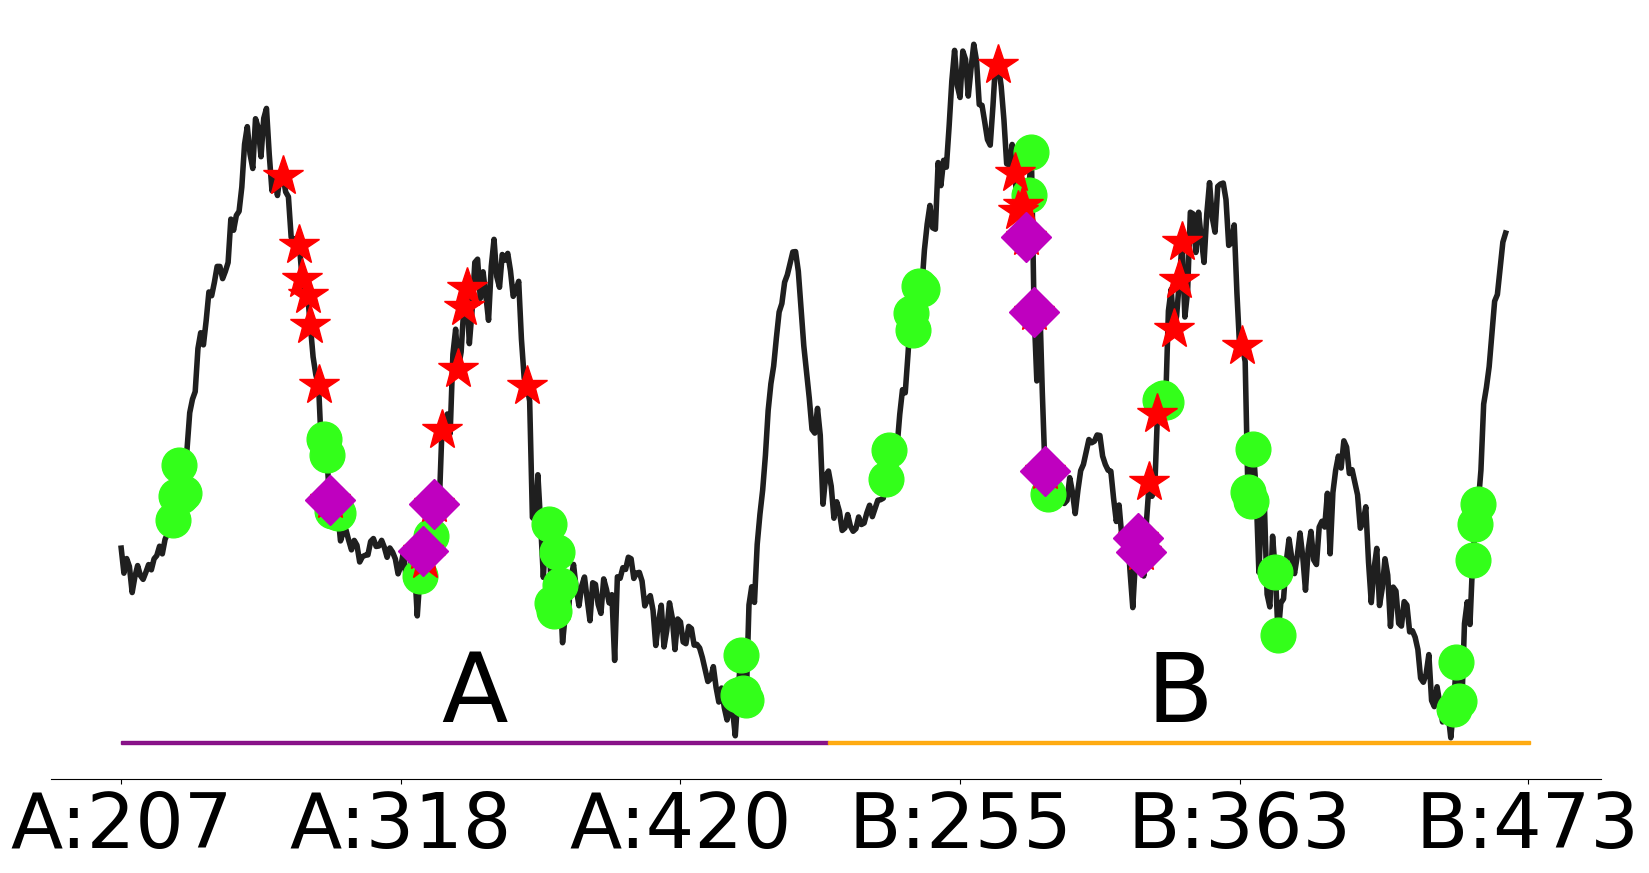

In [244]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
plt.sca(ax)  # Set current axis to 'ax'
    
# Increase font sizes
plt.rc('xtick', labelsize=55)
plt.rc('ytick', labelsize=50)
plt.rcParams.update({'font.size': 70})

# calcMSF
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row-8):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / AverageEigVals1[mode]
    MSF.append(currMSF)

plt.plot(MSF, color='black', linewidth=4, alpha=0.88)    

HingeY = [MSF[item] for item in currHinge]
plt.plot(currHinge, HingeY, color=(0.2, 1, 0.1), marker='o', linestyle='', markersize=25)
print ('# of hinges', len(HingeY))

# plot binding sites
bindingY = [MSF[item] for item in binding]
plt.plot(binding, bindingY, 'r*', markersize=30)
print ('# of bindings sites', len(binding))

# plot overlaps
allHinge = currHinge
overlaps = [item for item in binding if item in allHinge]
overlapsY = [MSF[item] for item in overlaps]
plt.plot(overlaps, overlapsY, 'mD', markersize=25)

print ('# of hits are', len(overlaps))

# Hide y labels
plt.gca().yaxis.set_visible(False)

# Hide top, right, and left spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

y = MSF
# Determine the lower y-limit for bands and labels
lower_y_limit = min(y) * 0.1
upper_y_limit = min(y) * 0.5

# Add narrow bands below the plot
ax.add_patch(patches.Rectangle((0, lower_y_limit), SplitLabel, upper_y_limit - lower_y_limit, color='purple', alpha=0.9))
ax.add_patch(patches.Rectangle((SplitLabel, lower_y_limit), proteinLength - SplitLabel, upper_y_limit - lower_y_limit, color='orange',alpha=0.9))
# Add labels just above the bands
ax.text(SplitLabel / 2, upper_y_limit, 'A', color='black', ha='center', va='bottom')
ax.text((SplitLabel + proteinLength) / 2, upper_y_limit, 'B', color='black', ha='center', va='bottom')

# Set x-axis labels and title with Arial font
# plt.title('Peroxisome Proliferator-activated \nReceptor gamma')
plt.xticks([0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1], Labels)

plt.savefig('./PPARg_MSF.png', dpi=500)

In [245]:
AverageEigVals1

sdarray([ 0.19108978,  0.58242401,  0.70377338,  0.82148101,  1.10886961,
          1.20829941,  1.79408945,  1.90760233,  2.11875951,  2.23694006,
          2.44502643,  2.63999203,  2.72014404,  2.85635134,  3.02494603,
          3.24792435,  3.35806931,  3.46725223,  3.66915226,  3.92731388,
          4.27254828,  4.36927496,  4.4683385 ,  4.78222185,  5.0589335 ,
          5.35999297,  5.44331977,  5.62941794,  5.75782971,  5.89198686,
          5.93909934,  6.0188174 ,  6.19111224,  6.29632686,  6.41399602,
          6.46282666,  6.64001724,  6.71703318,  6.90322583,  6.92429323,
          6.98296972,  7.14622359,  7.3792104 ,  7.47475022,  7.52619855,
          7.73958047,  7.88630371,  7.93186954,  8.        ,  8.        ,
          8.        ,  8.09780819,  8.16961433,  8.18554797,  8.25960755,
          8.32280355,  8.52371016,  8.5390158 ,  8.55142277,  8.59860432,
          8.65879217,  8.72703866,  8.86404978,  8.94930933,  9.04902942,
          9.09248856,  9.2732181 ,  9.

### write hinges

In [219]:
averageEigVects.shape

(514, 367)

In [220]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)                                          

514

In [221]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [222]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [223]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 258], [259, 513]], 15)
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [224]:
writeAllData('./Data/PPARg_Method2_similar.txt', curr)

# Method 3

In [165]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [166]:
protein_length = 514

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 28
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 6 0 1
# of hinge sites for first 3 modes, overlap, hyper score 49 5 0.11663245597579841
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 6 0 1
# of hinge sites for first 3 modes, overlap, hyper score 49 5 0.11663245597579841


In [167]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [[]], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [[], [], []], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [[]], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [[], [], []], 15)

In [169]:
protein_length = 514

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 28
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 6 0 1
# of hinge sites for first 3 modes, overlap, hyper score 49 5 0.11663245597579841
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 6 0 1
# of hinge sites for first 3 modes, overlap, hyper score 49 5 0.11663245597579841


In [35]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [36]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes3(averageEigVects, mode, [], bandWidth=15)
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [37]:
writeAllData('./Data/PR_Method3_update.txt', curr)

# StoreData

In [359]:
# write modes
writeNumbers('./Data/mode1.txt', averageEigVects[:, 0])
writeNumbers('./Data/mode2.txt', averageEigVects[:, 1])
writeNumbers('./Data/mode3.txt', averageEigVects[:, 2])


In [387]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
           
writeNumbers('./Data/MSF_mode123.txt', MSF)
writeNumbers('./Data/RMSF_mode123.txt', sqrt(MSF))

In [388]:
# RMSF minimum
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

writeNumbers('./Data/RMSF_minimum.txt', indices)

# Plot graph

In [187]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


# Plot single graph

In [209]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(15, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 258], [259, 513]], 15)
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge, len(currHinge))
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./PPARg_method2_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [] 0
local loop motion []
current bindings are [59, 65, 66, 68, 69, 72, 76, 110, 111, 114, 117, 123, 125, 126, 148, 320, 326, 327, 329, 330, 333, 337, 371, 372, 375, 378, 384, 386, 387, 409]
current hits are []
# of overlaps finding from current mode is 0


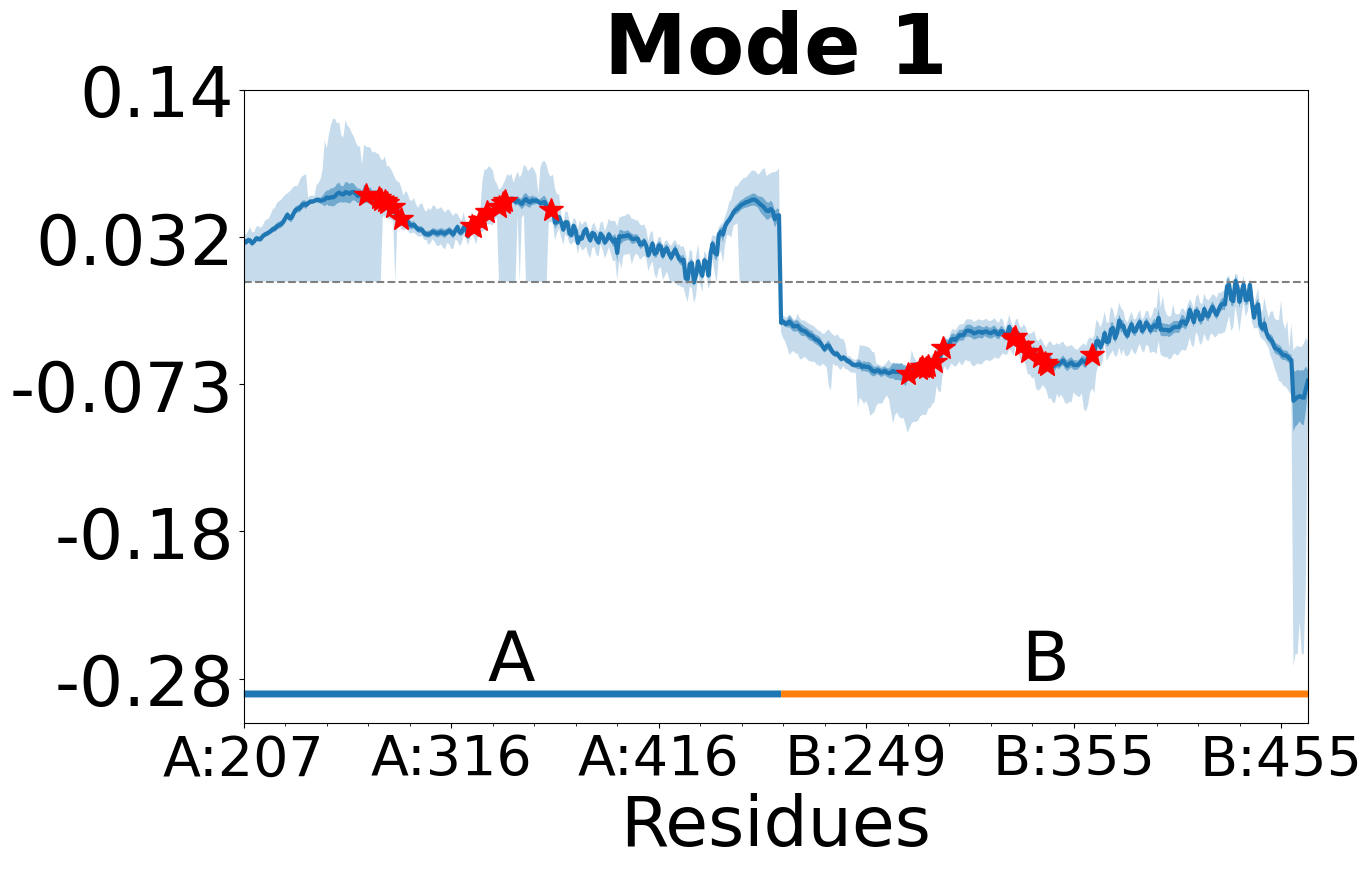

In [210]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [19, 20, 411, 412, 157, 158, 159, 160, 288, 289, 291, 292, 413, 76, 77, 78, 79, 337, 338, 226, 227, 228, 109, 110, 493, 494, 495, 379, 380, 381] 30
local loop motion []
current bindings are [59, 65, 66, 68, 69, 72, 76, 110, 111, 114, 117, 123, 125, 126, 148, 320, 326, 327, 329, 330, 333, 337, 371, 372, 375, 378, 384, 386, 387, 409]
current hits are [76, 110, 337]
# of overlaps finding from current mode is 3


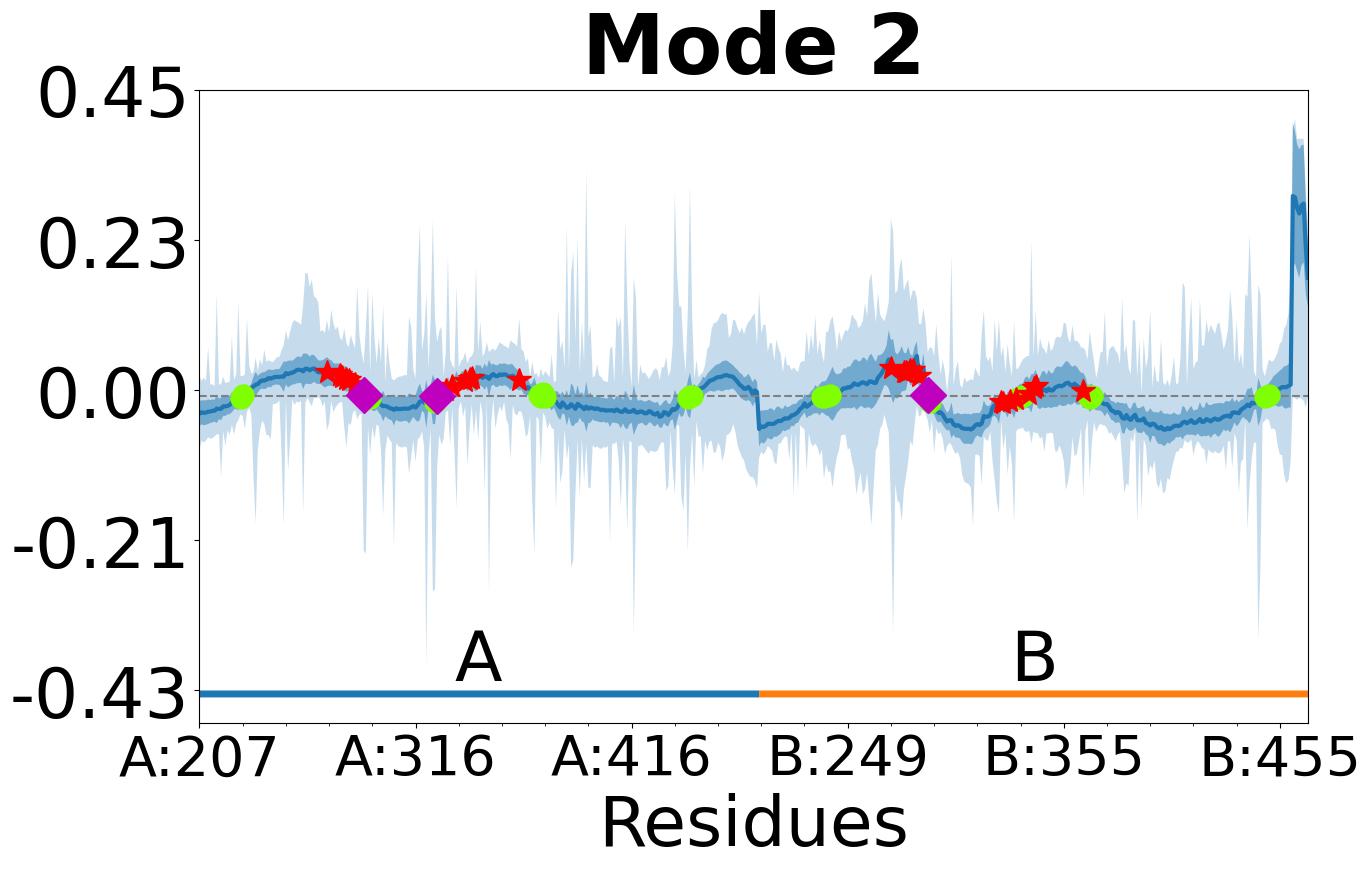

In [211]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [20, 21, 22, 279, 23, 280, 156, 157, 421, 422, 74, 75, 330, 333, 331, 332, 225, 226, 227, 228, 486, 487, 488, 113, 114, 371, 372] 27
local loop motion []
current bindings are [59, 65, 66, 68, 69, 72, 76, 110, 111, 114, 117, 123, 125, 126, 148, 320, 326, 327, 329, 330, 333, 337, 371, 372, 375, 378, 384, 386, 387, 409]
current hits are [114, 330, 333, 371, 372]
# of overlaps finding from current mode is 5


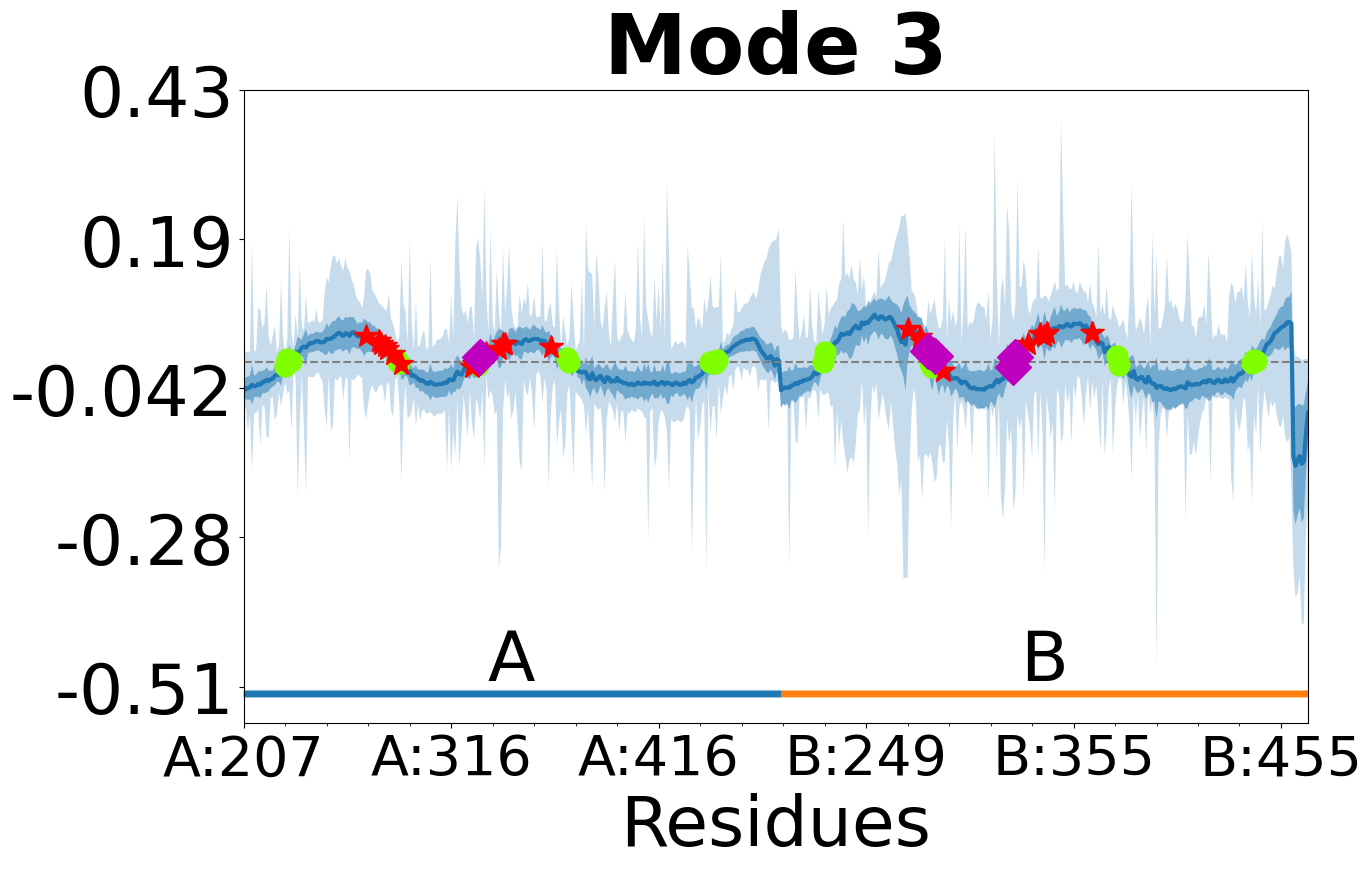

In [212]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

In [225]:
ORA(30, 514, 42, 8)

0.0015374435368183947

In [60]:
def plotSingleGraph_method3(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(15, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method3
    currHinge = getHinges_modes3(averageEigVects, mode, Hinge, bandWidth = 15)
    
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge)
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    # updateHinge = [item for item in Hinge if item not in currHinge]
    # HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    # print ('local loop motion', updateHinge)
    # plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./HIV1-PR_method3_mode' + str(mode + 1) + '.png', dpi=500)

[50, 51]
[101, 102]
[149, 150]
Hinge residue with wide bands [96, 101, 102, 50, 51, 149, 150, 95]
current bindings are [23, 25, 27, 28, 29, 30, 32, 47, 48, 49, 50, 83, 84, 86, 124, 126, 128, 129, 130, 131, 133, 149, 150, 151, 152, 183, 184, 185, 187]
current hits are [50, 149, 150]
# of overlaps finding from current mode is 3


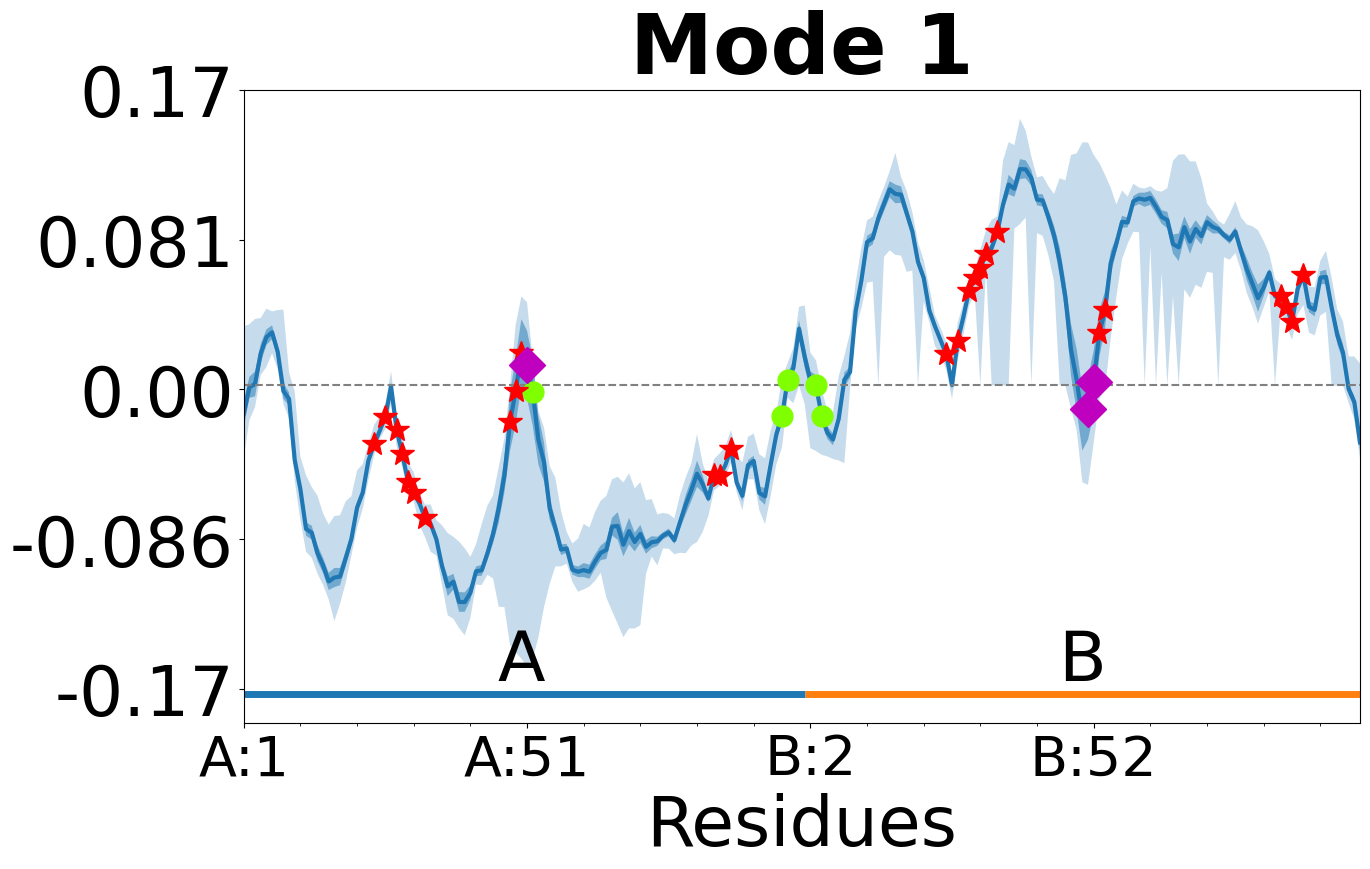

In [64]:
modes = 0 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, Hinge0)

[14, 15]
Hinge residue with wide bands [160, 129, 130, 161, 72, 73, 171, 172, 14, 15, 82, 83, 181, 182, 62, 61, 30, 31]
current bindings are [23, 25, 27, 28, 29, 30, 32, 47, 48, 49, 50, 83, 84, 86, 124, 126, 128, 129, 130, 131, 133, 149, 150, 151, 152, 183, 184, 185, 187]
current hits are [30, 83, 129, 130]
# of overlaps finding from current mode is 4


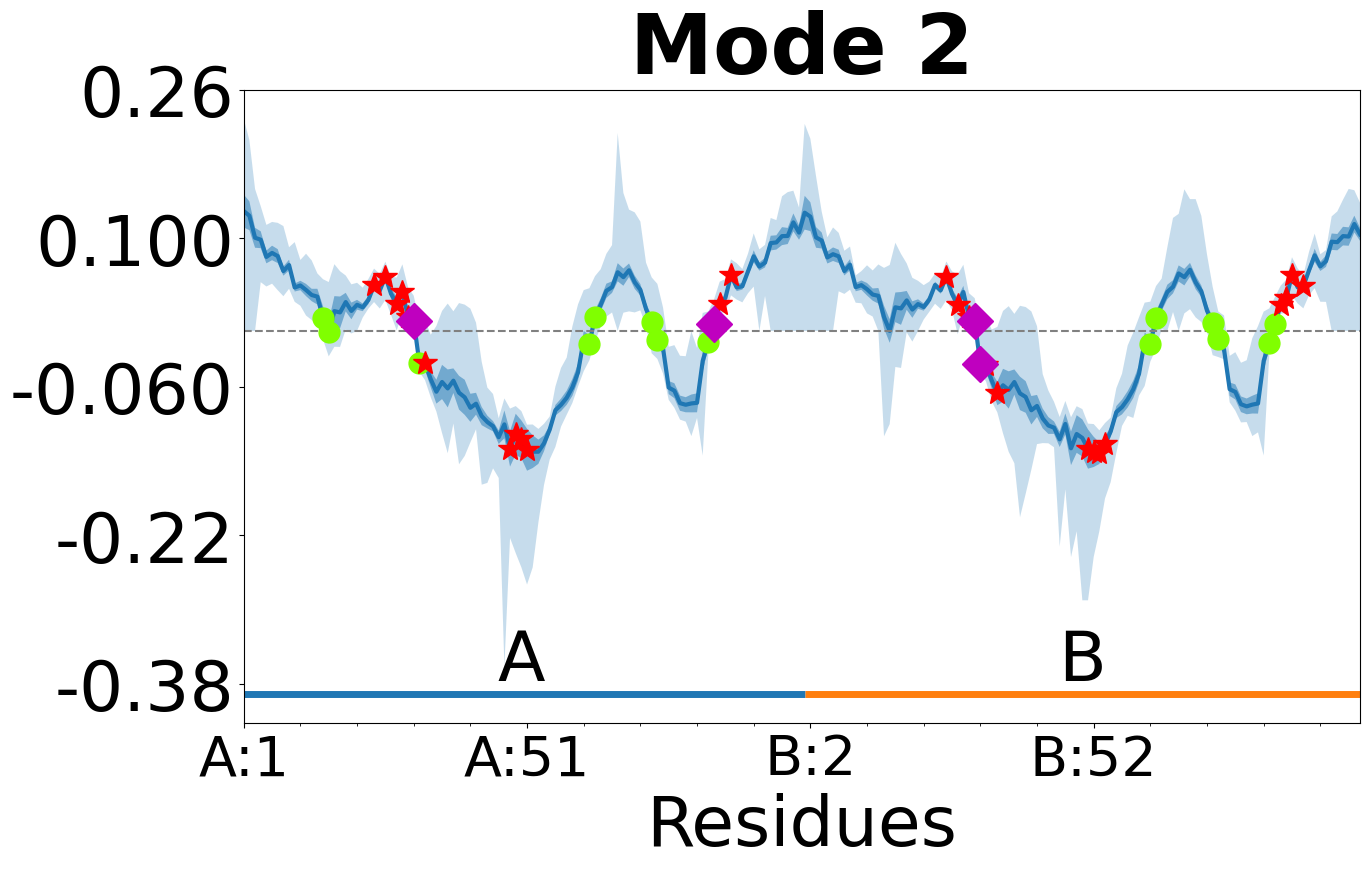

In [62]:
modes = 1 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, Hinge1)

[50, 51]
Hinge residue with wide bands [128, 129, 147, 148, 150, 151, 30, 31, 160, 161, 171, 172, 50, 51, 181, 182, 61, 62, 72, 73, 82, 83, 96, 101, 102, 106, 125]
current bindings are [23, 25, 27, 28, 29, 30, 32, 47, 48, 49, 50, 83, 84, 86, 124, 126, 128, 129, 130, 131, 133, 149, 150, 151, 152, 183, 184, 185, 187]
current hits are [30, 50, 83, 128, 129, 150, 151]
# of overlaps finding from current mode is 7


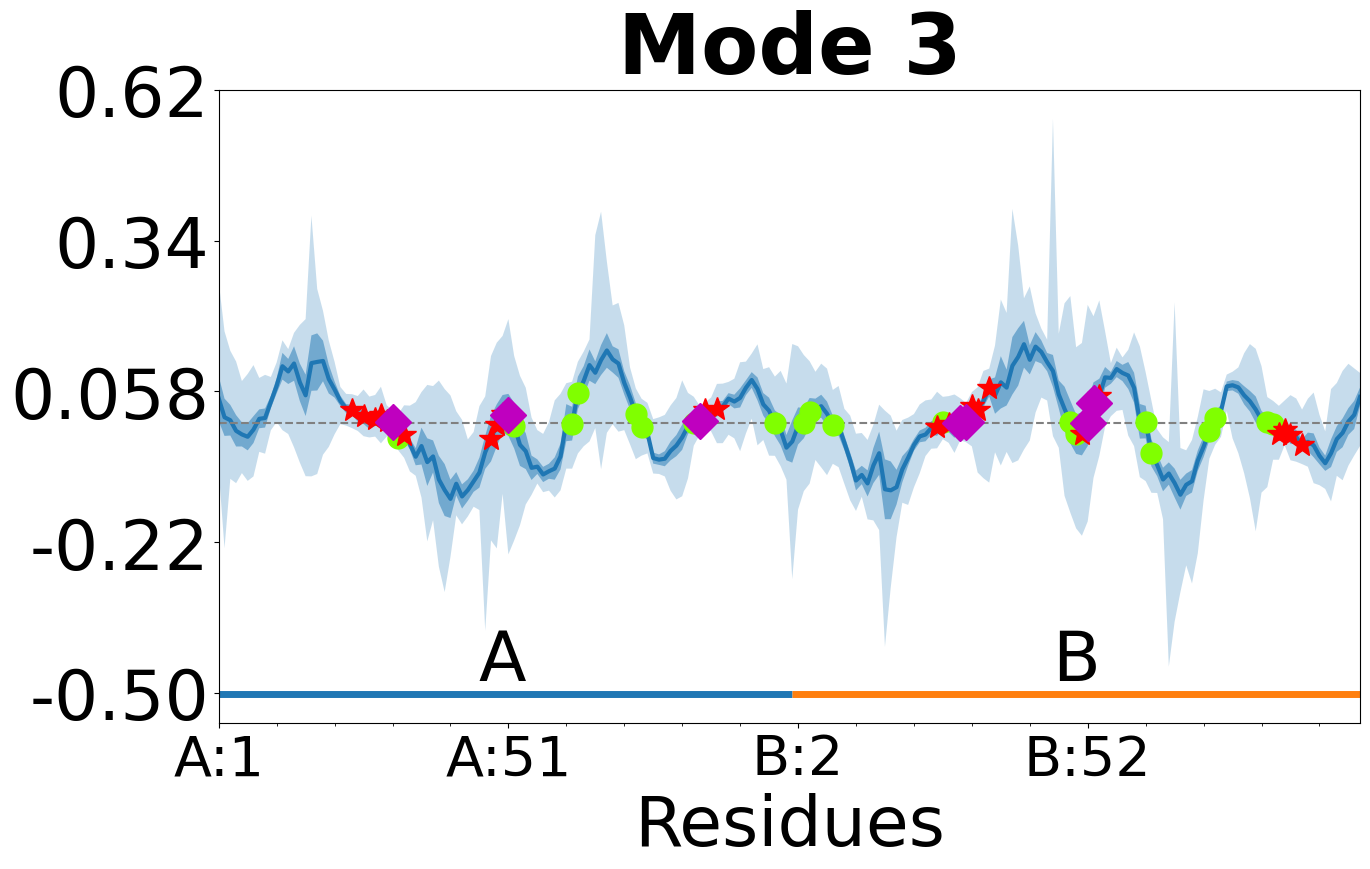

In [63]:
modes = 2 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, Hinge2)

# Write Modes

In [84]:
len(averageEigVects[:, 0])

514

In [97]:
mode = 2

In [98]:
residue = []
new_b_factor = []

for item in averageEigVects[:, mode]:
    new_b_factor.append(item)

In [99]:
resiIndex = [x for x in range(207, 266)]
chain = ['A' for x in range(207, 266)]

resiIndex += [x for x in range(275, 475)]
chain += ['A' for x in range(275, 475)]


resiIndex += [x for x in range(207, 239)]
chain += ['B' for x in range(207, 239)]

resiIndex += [x for x in range(240, 269)]
chain += ['B' for x in range(240, 269)]

resiIndex += [x for x in range(275, 461)]
chain += ['B' for x in range(275, 461)]

resiIndex += [x for x in range(466, 474)]
chain += ['B' for x in range(466, 474)]

In [100]:
len(resiIndex)

514

In [101]:
len(chain)

514

In [102]:
with open('./structure_demo/PPARg_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
    for i in range(len(resiIndex)):
        # print (chain[i])
        wf.write(chain[i] + ', ' + str(resiIndex[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [43]:
!pwd

/data/frank/Desktop/Hinges_Figures_all/HIV-PR
